# Gesture Recognition

A home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command that are as followed:

Gesture | Action
--------|--------
Thumbs up |  Increase the volume
Thumbs down | Decrease the volume
Left swipe | 'Jump' backwards 10 seconds
Right swipe | 'Jump' forward 10 seconds  
Stop | Pause the movie
<br>
<br>

### Objectives:<br>
1. **Generator:** The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully. <br>

2. **Model:** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further. <br>

3. **Write up:** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.<br>

### Importing Packages and setting up seed value

In [8]:
import numpy as np
import os
import datetime
import os
import matplotlib.pyplot as plt
from imageio import imread
from skimage import io, transform
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [9]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

#### Initialize path and vairables

In [10]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

# Batch size handled in class

batch_size = 30  # Will be passed to function run_model
img_size_ht = 120
img_size_wd = 120

### Defining Generator Function

In [11]:
def generator(source_path, folder_list, batch_size, factor_ht=0, factor_wd=0 ):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = np.arange(0,30,2) #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)


        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] /255
                    batch_data[folder,idx,:,:,1] = image[:,:,1] /255
                    batch_data[folder,idx,:,:,2] = image[:,:,2] /255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                   # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
                    image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

#### Defining Fit function for the models

In [26]:
def run_model(model, batch_size = 30, epoch_num=25):
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = generator(train_path, train_doc, batch_size)
        val_generator = generator(val_path, val_doc, batch_size)
        
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5) # write the REducelronplateau code here
        
        callbacks_list = [checkpoint, LR]
        
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
       
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, 
        # you'll be able to save the model at the end of each epoch.
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch_num, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        return history

### Defining Fit function for the models

In [ ]:
def run_model(model, batch_size = 30, epoch_num=25):
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = generator(train_path, train_doc, batch_size)
        val_generator = generator(val_path, val_doc, batch_size)
        

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5) # write the REducelronplateau code here
        
        callbacks_list = [checkpoint, LR]
        
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
       
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, 
        # you'll be able to save the model at the end of each epoch.
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch_num, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        return history

#### Defining Loss function that will be used to plot the graph

In [12]:
def loss(history):
        acc = history.history['categorical_accuracy']
        val_acc = history.history['val_categorical_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(len(history.history['loss']))

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

**More parameters**

In [21]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs. However this is a variable that can be passed to function
print ('# epochs =', num_epochs)
num_classes = 5

# training sequences = 663
# validation sequences = 100
# epochs = 25


### Testing Generator function

Source path =  Project_data/train ; batch size = 32


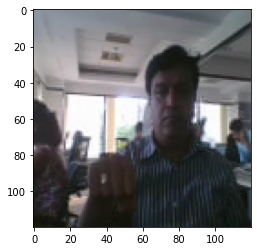

In [44]:
# Test Generator Function

xtrain=generator(train_path,train_doc, 32 )
x=next(xtrain)
plt.imshow(x[0][1][1])
plt.show()

Source path =  Project_data/train ; batch size = 32


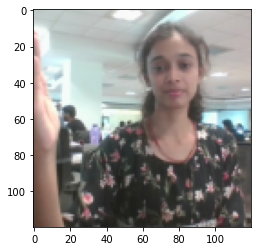

In [45]:
# Test Crop in Generator Function

xtrain=generator(train_path,train_doc, 32, factor_ht=10, factor_wd=10)
x=next(xtrain)
plt.imshow(x[0][1][1])
plt.show()

### Define Keras Classes

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, LeakyReLU
from tensorflow.keras.applications import EfficientNetB0

# Developing Models

### Model 1 



In [16]:
#write your model here

Input_shape = (15, img_size_ht,img_size_wd, 3)
model_1 = Sequential()
model_1.add(Conv3D(8, (3,3,3), padding='same',
                 input_shape=Input_shape))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(Conv3D(16, (3, 3,3)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2, 2,2)))

model_1.add(Dropout(0.5))

model_1.add(Conv3D(32, (3, 3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(Conv3D(64, (3, 3,3)))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2,2)))

model_1.add(Dropout(0.5))

model_1.add(Flatten())

model_1.add(Dense(5))
model_1.add(Activation('softmax'))

In [17]:
optimiser = Adam(learning_rate=0.001) 
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 120, 120, 8)   656       
                                                                 
 batch_normalization_4 (Batc  (None, 15, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 15, 120, 120, 8)   0         
                                                                 
 conv3d_5 (Conv3D)           (None, 13, 118, 118, 16)  3472      
                                                                 
 batch_normalization_5 (Batc  (None, 13, 118, 118, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 13, 118, 118, 16) 

In [25]:
history= run_model(model_1)

Source path =  Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 9.3448 - categorical_accuracy: 0.4902 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-04-1120_39_13.375369\model-00001-9.34477-0.49020-8.19101-0.19000.h5
23/23 [==============================] - 312s 14s/step - loss: 9.3448 - categorical_accuracy: 0.4902 - val_loss: 8.1910 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 6.2715 - categorical_accuracy: 0.5822 
Epoch 2: saving model to model_init_2022-04-1120_39_13.375369\model-00002-6.27151-0.58220-12.34148-0.13000.h5
23/23 [==============================] - 311s 14s/step - loss: 6.2715 - categorical_accuracy: 0.5822 - val_loss: 12.3415 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/25
15/23 [==================>...........] - ETA: 1:44 - loss: 3.7729 - categorical_accuracy: 0.6933

KeyboardInterrupt: 

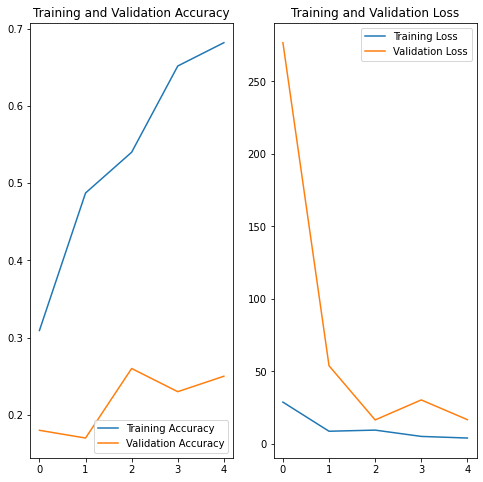

In [50]:
loss(history)

This is Complete Overfit. But seeing the ipward trend in accracy and Validation Loss, running the model for more epoch we could see improvement in Validation parameters.

### Model 2 


- Try out with **Leaky Relu** and increasing complexity of architecture. 
- We have added Dense layers with **elu** activation

In [54]:
# Define Model

lrelu = lambda x: LeakyReLU(alpha=0.1)(x)

model_2 = Sequential()

model_2.add(Conv3D(8,(3,3,3),  padding='same', input_shape= (15,100,100,3) ))
model_2.add(BatchNormalization())
model_2.add(Activation(lrelu))
model_2.add(Conv3D(16,(3,3,3),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation(lrelu))
model_2.add(Dropout(0.5))
model_2.add(MaxPooling3D(pool_size= (2,2,2)))

model_2.add(Conv3D(32,(3,3,3),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation(lrelu))
model_2.add(Conv3D(64,(3,3,3),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation(lrelu))
model_2.add(Dropout(0.5))
model_2.add(MaxPooling3D(pool_size= (2,2,2)))

model_2.add(Conv3D(128,(3,3,3),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation(lrelu))
model_2.add(Conv3D(256,(3,3,3),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation(lrelu))
model_2.add(Dropout(0.5))
model_2.add(MaxPooling3D(pool_size= (2,2,2)))

model_2.add(Flatten())

model_2.add(Dense(64))
model_2.add(BatchNormalization())
model_2.add(Activation('elu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(32))
model_2.add(BatchNormalization())
model_2.add(Activation('elu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(5, activation='softmax'))

In [55]:
optimiser = Adam(learning_rate=0.001) 
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization_28 (Bat  (None, 15, 100, 100, 8)  32        
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 15, 100, 100, 8)   0         
                                                                 
 conv3d_15 (Conv3D)          (None, 15, 100, 100, 16)  3472      
                                                                 
 batch_normalization_29 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 15, 100, 100, 16) 

In [56]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_7/flatten_7/Reshape' defined at (most recent call last):
    File "D:\Anaconda\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Anaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\Anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "D:\Anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\Anaconda\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "D:\Anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "D:\Anaconda\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "D:\Anaconda\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "D:\Anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\Anaconda\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "D:\Anaconda\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\shubh\AppData\Local\Temp/ipykernel_13048/521890477.py", line 28, in <module>
      history = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "D:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "D:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "D:\Anaconda\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "D:\Anaconda\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\layers\core\flatten.py", line 96, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_7/flatten_7/Reshape'
Input to reshape is a tensor with 1728000 values, but the requested shape requires a multiple of 36864
	 [[{{node sequential_7/flatten_7/Reshape}}]] [Op:__inference_train_function_70184]

In [ ]:
loss(history)

There is no improvement in Validation parameters as seen from above

### Model 3
- Changing the architecture and updating the activation for Dense Layer with **relu**
- Also we have used RMSProp as Optimizer

In [57]:
# Define Model

model_3 = Sequential()

model_3.add(Conv3D(8,(3,3,3),   padding='same', input_shape= (15,img_size_ht,img_size_wd,3) ))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size= (2,2,2)))

model_3.add(Conv3D(16,(3,3,3),padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size= (2,2,2)))

model_3.add(Conv3D(32,(1,3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size= (2,2,2)))

model_3.add(Conv3D(64,(1,2,2), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size= (1,3,3)))

model_3.add(Flatten())

model_3.add(Dense(1000, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(500, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(5, activation='softmax'))

In [58]:
optimiser = RMSprop(learning_rate=0.001) 
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 15, 120, 120, 8)   656       
                                                                 
 batch_normalization_36 (Bat  (None, 15, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 15, 120, 120, 8)   0         
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 7, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 7, 60, 60, 16)     3472      
                                                                 
 batch_normalization_37 (Bat  (None, 7, 60, 60, 16)   

In [59]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 5.7497 - categorical_accuracy: 0.2353Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-5.74975-0.23529-1.70210-0.23000.h5
23/23 [==============================] - 177s 8s/step - loss: 5.7497 - categorical_accuracy: 0.2353 - val_loss: 1.7021 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.6791 - categorical_accuracy: 0.3469
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.67906-0.34691-1.72647-0.17000.h5
23/23 [==============================] - 177s 8s/step - loss: 1.6791 - categorical_accuracy: 0.3469 - val_loss: 1.7265 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.5245 - categorical_accuracy: 0.4208
Epoch 3: saving model to 

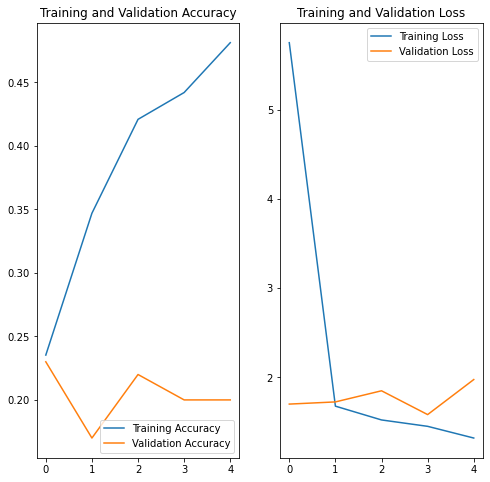

In [60]:
loss(history)

This is Complete Overfit. But seeing the trend in accracy and Validation Loss, running the model for more EPOCH we could see improvement in Validation parameters.

### Model 4
- Adding one more Conv3D layer wiht 128 filters.
- We have changed the second last Conv3D filter size from 1,3,3 to 3,3,3 
- For the last CNN layers the filter size is changed from 1,2,2 to 3,3,3
- Same Optimizer is used as in Model 3

In [61]:
# Define Model

model_4 = Sequential()

model_4.add(Conv3D(8,(3,3,3),   padding='same', input_shape= (15,img_size_ht,img_size_wd,3) ))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))

model_4.add(Conv3D(16,(3,3,3),padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))

model_4.add(MaxPooling3D(pool_size= (2,2,2)))

model_4.add(Conv3D(32,(3,3,3),padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))

model_4.add(Conv3D(64,(3,3,3), padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))

model_4.add(Conv3D(128,(3,3,3),padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))

model_4.add(MaxPooling3D(pool_size= (1,3,3)))

model_4.add(Flatten())

model_4.add(Dense(1000))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.25))

model_4.add(Dense(500))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.25))

model_4.add(Dense(5, activation='softmax'))

In [62]:
optimiser = RMSprop(learning_rate=0.001) 
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 15, 120, 120, 8)   656       
                                                                 
 batch_normalization_40 (Bat  (None, 15, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 15, 120, 120, 8)   0         
                                                                 
 dropout_22 (Dropout)        (None, 15, 120, 120, 8)   0         
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 120, 120, 16)  3472      
                                                                 
 batch_normalization_41 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                     

In [63]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.4610 - categorical_accuracy: 0.4540 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.46103-0.45400-10.26849-0.21000.h5
23/23 [==============================] - 1116s 48s/step - loss: 1.4610 - categorical_accuracy: 0.4540 - val_loss: 10.2685 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 0.7508 - categorical_accuracy: 0.7315 
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-0.75084-0.73152-11.73737-0.18000.h5
23/23 [==============================] - 1119s 48s/step - loss: 0.7508 - categorical_accuracy: 0.7315 - val_loss: 11.7374 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 0.5982 - categorical_accuracy: 0.7768 
Epoch 3: savin

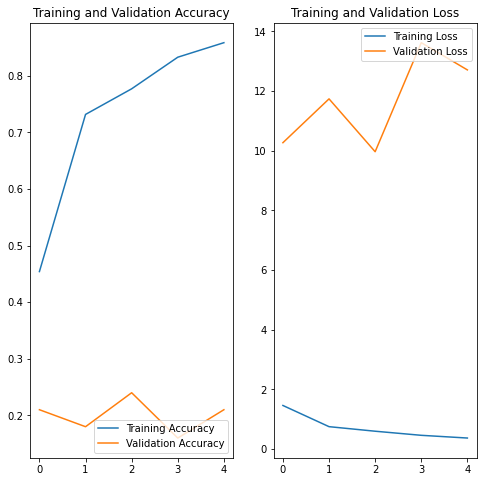

In [64]:
loss(history)

The model shows a downward trend. Hence does not seem to be a good choice.

### Model 5

- This time running the model with Adam optimizer

In [65]:
# Define Model

model_5 = Sequential()

model_5.add(Conv3D(8,(3,3,3),   padding='same', input_shape= (15,img_size_ht,img_size_wd,3) ))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.5))

model_5.add(Conv3D(16,(3,3,3),padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.5))
model_5.add(MaxPooling3D(pool_size= (2,2,2)))


model_5.add(Conv3D(32,(3,3,3), padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.5))
model_5.add(Conv3D(64,(3,3,3),padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.5))

model_5.add(MaxPooling3D(pool_size= (2,2,2)))

model_5.add(Conv3D(64,(3,3,3), padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.5))

model_5.add(Conv3D(128,(3,3,3),padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.5))

model_5.add(MaxPooling3D(pool_size= (1,2,2)))

model_5.add(Flatten())

model_5.add(Dense(1000))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.25))

model_5.add(Dense(500))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.25))

model_5.add(Dense(5, activation='softmax'))

In [66]:
optimiser = Adam(learning_rate=0.001) 
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_29 (Conv3D)          (None, 15, 120, 120, 8)   656       
                                                                 
 batch_normalization_47 (Bat  (None, 15, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_47 (Activation)  (None, 15, 120, 120, 8)   0         
                                                                 
 dropout_29 (Dropout)        (None, 15, 120, 120, 8)   0         
                                                                 
 conv3d_30 (Conv3D)          (None, 15, 120, 120, 16)  3472      
                                                                 
 batch_normalization_48 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                    

In [67]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.4911 - categorical_accuracy: 0.4480 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.49108-0.44796-2.65223-0.21000.h5
23/23 [==============================] - 568s 25s/step - loss: 1.4911 - categorical_accuracy: 0.4480 - val_loss: 2.6522 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 0.8148 - categorical_accuracy: 0.6983 
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-0.81475-0.69834-3.43229-0.19000.h5
23/23 [==============================] - 559s 24s/step - loss: 0.8148 - categorical_accuracy: 0.6983 - val_loss: 3.4323 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 0.7612 - categorical_accuracy: 0.7270 
Epoch 3: saving mode

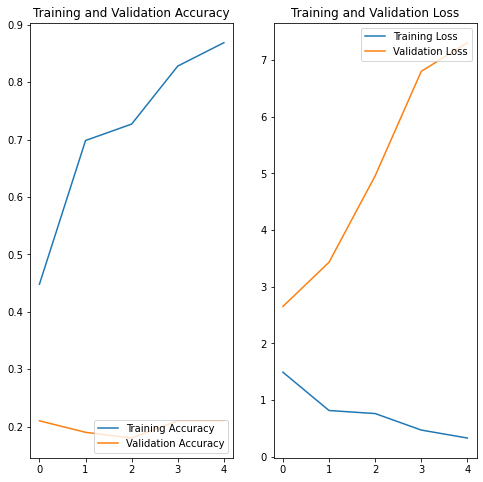

In [68]:
loss(history)

The loss from this model is also widening as in model 5. So this model is also not too good.

### Model 6
- Using Model 3 architecture again
- Using elu Activation Function

In [69]:
# Define Model

model_6 = Sequential()

model_6.add(Conv3D(8,(3,3,3),   padding='same', input_shape= (15,img_size_ht,img_size_wd,3) ))
model_6.add(BatchNormalization())
model_6.add(Activation('elu'))
model_6.add(MaxPooling3D(pool_size= (2,2,2)))

model_6.add(Conv3D(16,(3,3,3),padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('elu'))
model_6.add(MaxPooling3D(pool_size= (2,2,2)))

model_6.add(Conv3D(32,(1,3,3), padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('elu'))
model_6.add(MaxPooling3D(pool_size= (2,2,2)))

model_6.add(Conv3D(64,(1,2,2), padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('elu'))
model_6.add(MaxPooling3D(pool_size= (1,3,3)))

model_6.add(Flatten())

model_6.add(Dense(1000, activation='elu'))
model_6.add(Dropout(0.5))

model_6.add(Dense(500, activation='elu'))
model_6.add(Dropout(0.5))

model_6.add(Dense(5, activation='softmax'))

In [70]:
optimiser = RMSprop(learning_rate=0.001) 
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_35 (Conv3D)          (None, 15, 120, 120, 8)   200       
                                                                 
 conv3d_36 (Conv3D)          (None, 14, 119, 119, 16)  1040      
                                                                 
 dropout_37 (Dropout)        (None, 14, 119, 119, 16)  0         
                                                                 
 batch_normalization_55 (Bat  (None, 14, 119, 119, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 7, 59, 59, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 7, 59, 59, 32)   

In [71]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 2.5683 - categorical_accuracy: 0.2368 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-2.56825-0.23680-1.61112-0.22000.h5
23/23 [==============================] - 349s 15s/step - loss: 2.5683 - categorical_accuracy: 0.2368 - val_loss: 1.6111 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.3520 - categorical_accuracy: 0.4646 
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.35202-0.46456-1.64812-0.15000.h5
23/23 [==============================] - 346s 15s/step - loss: 1.3520 - categorical_accuracy: 0.4646 - val_loss: 1.6481 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.1340 - categorical_accuracy: 0.5837 
Epoch 3: saving mode

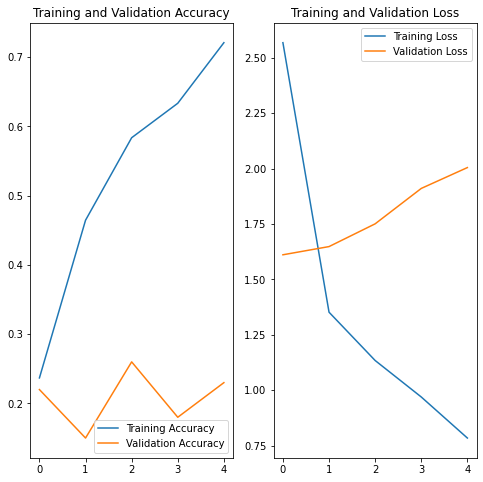

In [72]:
loss(history)

Accuracy increases but the loss is widening.

## Let's try with Conv-2d with RNN (LSTM and GRU)

### Model 7
- Switching Architecture to CNN + LSTM with Adam Optimizer

In [73]:
model_7 = Sequential()

model_7.add(TimeDistributed(Conv2D(16, (3,3), padding = "same"), input_shape=(15,img_size_ht,img_size_wd,3)))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))
           
model_7.add(TimeDistributed(Conv2D(32,(3,3),padding = "same")))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))
model_7.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_7.add(TimeDistributed(Conv2D(64, (3,3),  padding = "same")))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))
model_7.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))
           
model_7.add(TimeDistributed(Conv2D(128,(3,3), padding = "same")))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))       
model_7.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_7.add(TimeDistributed(Conv2D(256,(3,3), padding = "same")))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))          
model_7.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))


model_7.add(TimeDistributed(Flatten()))
model_7.add(LSTM(256,dropout=0.2))
model_7.add(Dense(256, activation='relu'))
model_7.add(Dropout(0.2))

model_7.add(Dense(5, activation='softmax'))

In [74]:
optimiser = Adam(learning_rate=0.001) 
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 15, 120, 120, 16)  0        
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 15, 120, 120, 32)  4640     
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 15, 120, 120, 32

In [75]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.5815 - categorical_accuracy: 0.2685Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.58146-0.26848-1.63069-0.18000.h5
23/23 [==============================] - 170s 7s/step - loss: 1.5815 - categorical_accuracy: 0.2685 - val_loss: 1.6307 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.2683 - categorical_accuracy: 0.5143
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.26829-0.51433-1.69347-0.16000.h5
23/23 [==============================] - 170s 7s/step - loss: 1.2683 - categorical_accuracy: 0.5143 - val_loss: 1.6935 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.0894 - categorical_accuracy: 0.5716
Epoch 3: saving model to 

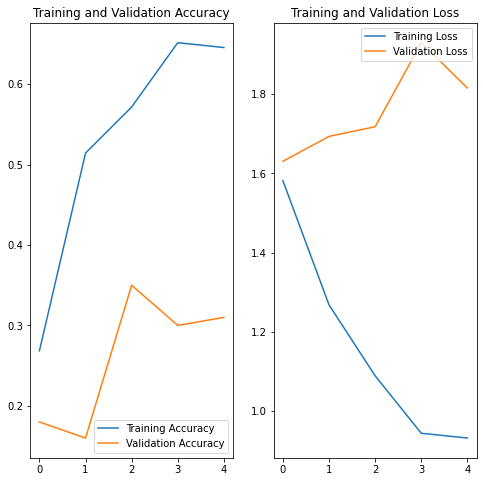

In [76]:
loss(history)

The Validation Accuracy looks promising here. Also the loss seems to have stabalized.

### Model 8
- Trying out the above architecture but this time with GRU

In [77]:
model_8 = Sequential()

model_8.add(TimeDistributed(Conv2D(16, (3,3), padding = "same"), input_shape=(15,img_size_ht,img_size_wd,3)))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(Activation('relu')))
           
model_8.add(TimeDistributed(Conv2D(32,(3,3),padding = "same")))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(Activation('relu')))
model_8.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_8.add(TimeDistributed(Conv2D(64, (3,3),  padding = "same")))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(Activation('relu')))
model_8.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))
           
model_8.add(TimeDistributed(Conv2D(128,(3,3), padding = "same")))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(Activation('relu')))       
model_8.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_8.add(TimeDistributed(Conv2D(256,(3,3), padding = "same")))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(Activation('relu')))          
model_8.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))


model_8.add(TimeDistributed(Flatten()))
model_8.add(GRU(256,dropout=0.2))
model_8.add(Dense(256, activation='relu'))
model_8.add(Dropout(0.2))

model_8.add(Dense(5, activation='softmax'))

In [78]:
optimiser = Adam(learning_rate=0.001) 
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_68 (TimeDi  (None, 15, 120, 120, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 15, 120, 120, 8)  32        
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 15, 120, 120, 8)  0         
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 15, 60, 60, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, 15, 60, 60, 16) 

In [79]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.7307 - categorical_accuracy: 0.2519Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.73073-0.25189-1.62460-0.21000.h5
23/23 [==============================] - 82s 4s/step - loss: 1.7307 - categorical_accuracy: 0.2519 - val_loss: 1.6246 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.4369 - categorical_accuracy: 0.3605
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.43691-0.36048-2.19157-0.14000.h5
23/23 [==============================] - 80s 4s/step - loss: 1.4369 - categorical_accuracy: 0.3605 - val_loss: 2.1916 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.2534 - categorical_accuracy: 0.4947
Epoch 3: saving model to Ge

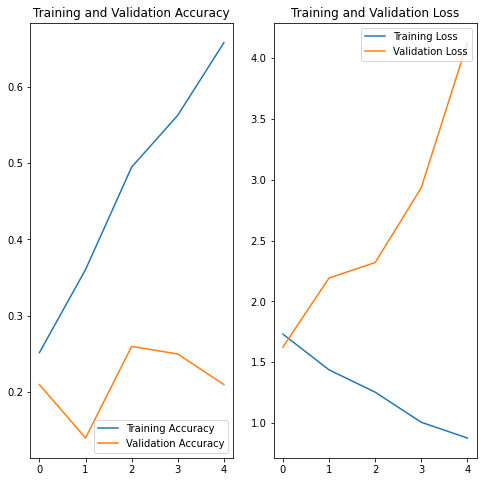

In [80]:
loss(history)

We can see almost similar result as with LSTM

## Trying out with Transfer Learning now

### Model 9
- Try out with Transfer Learning. We will try with the EfficientNetB0
- We have used GRU as this architecture is lighter

In [81]:
model_9 = Sequential()
model_9.add(TimeDistributed(EfficientNetB0(weights='imagenet', include_top=False),input_shape=(15,img_size_ht,img_size_wd,3)))

for layer in model_9.layers:
    layer.trainable = False

model_9.add(TimeDistributed(Flatten())) 

model_9.add(GRU(64))
model_9.add(Dropout(0.25))

model_9.add(Dense(64, activation='relu'))
model_9.add(Dropout(0.25))

model_9.add(Dense(5,activation='softmax'))

In [82]:
optimiser = Adam(learning_rate=0.001) 
model_9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_9.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_85 (TimeDi  (None, 15, 3, 3, 1280)   4049571   
 stributed)                                                      
                                                                 
 time_distributed_86 (TimeDi  (None, 15, 11520)        0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)                2224512   
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dropout_44 (Dropout)        (None, 64)              

In [83]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.8877 - categorical_accuracy: 0.1719Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.88774-0.17195-1.62653-0.23000.h5
23/23 [==============================] - 103s 4s/step - loss: 1.8877 - categorical_accuracy: 0.1719 - val_loss: 1.6265 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.7051 - categorical_accuracy: 0.2112
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.70509-0.21116-1.60763-0.15000.h5
23/23 [==============================] - 97s 4s/step - loss: 1.7051 - categorical_accuracy: 0.2112 - val_loss: 1.6076 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.6778 - categorical_accuracy: 0.2081
Epoch 3: saving model to G

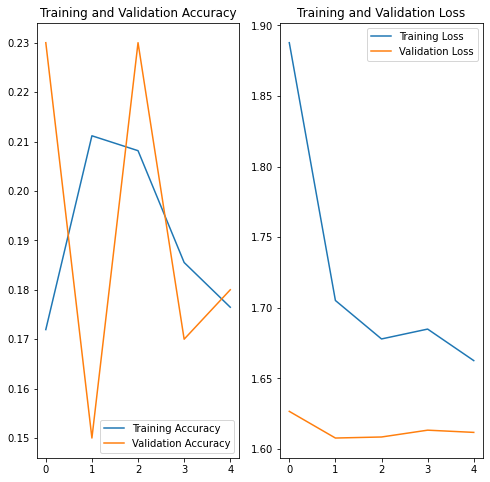

In [84]:
loss(history)

Although the accuracy is not high, but the model is not too overfit as seen in most of the earlier models

## Model 10
- Trying EffiecientNetB0 with two GRU layers
- Also we have used Dense Layer with elu activation layer

In [85]:
model_10 = Sequential()
model_10.add(TimeDistributed(EfficientNetB0(weights='imagenet', include_top=False),input_shape=(15,img_size_ht,img_size_wd,3)))

for layer in model_10.layers:
    layer.trainable = False

model_10.add(TimeDistributed(Flatten()))    
model_10.add(GRU(512,dropout=0.5, recurrent_dropout=0.15, return_sequences=True))
model_10.add(GRU(256,dropout=0.5))
model_10.add(Dense(256, activation='elu'))
model_10.add(Dropout(0.25))
model_10.add(Dense(5,activation='softmax'))

In [86]:
optimiser = Adam(learning_rate=0.001) 
model_10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_10.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_87 (TimeDi  (None, 15, 3, 3, 1280)   4049571   
 stributed)                                                      
                                                                 
 time_distributed_88 (TimeDi  (None, 15, 11520)        0         
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 15, 512)           18484224  
                                                                 
 gru_5 (GRU)                 (None, 256)               591360    
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dropout_45 (Dropout)        (None, 256)             

In [87]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 2.0278 - categorical_accuracy: 0.2036Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-2.02777-0.20362-1.70255-0.23000.h5
23/23 [==============================] - 137s 6s/step - loss: 2.0278 - categorical_accuracy: 0.2036 - val_loss: 1.7026 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.8409 - categorical_accuracy: 0.1991
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.84091-0.19910-1.74785-0.25000.h5
23/23 [==============================] - 128s 6s/step - loss: 1.8409 - categorical_accuracy: 0.1991 - val_loss: 1.7478 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.8005 - categorical_accuracy: 0.2021
Epoch 3: saving model to 

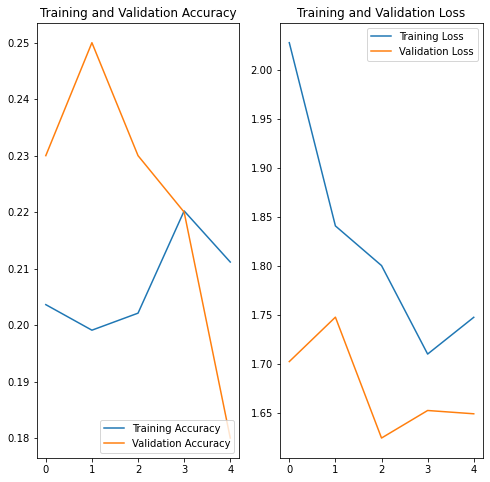

In [88]:
loss(history)

We still don't see much improvement here. Is Transfer Learning not working.

Trying out MobileNet

### Model 11

- Trying out Transfer Learning with Mobile Net.

In [5]:
from keras.applications import mobilenet

In [19]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_11 = Sequential()
model_11.add(TimeDistributed(mobilenet_transfer,input_shape=(15,img_size_ht,img_size_wd,3)))


for layer in model_11.layers:
    layer.trainable = False


model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(MaxPooling2D((2, 2))))
model_11.add(TimeDistributed(Flatten()))

model_11.add(GRU(256))
model_11.add(Dropout(0.2))

model_11.add(Dense(256,activation='elu'))
model_11.add(Dropout(0.2))

model_11.add(Dense(5, activation='softmax'))

17235968/17225924 [==============================] - 1s 0us/step


In [20]:
optimiser = Adam()
model_11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_11.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 256)              

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
loss(history)

This model showed the most promising results. We can consider using this as our final model.<br><br>

#### Of all the models ran, we tried out out the models that showed the most promising results, we would run the following models again:

 1. Model 1
 2. Model 3
 3. Model 7
 4. Model 8
 5. Model 11

Also increasing the num_epochs to 30. 

**In addition we would also start saving the models in h5 file**

In [90]:
num_epochs=30

### Re-running Model 1

In [91]:
train_generator = generator_new(train_path, train_doc, batch_size)
val_generator = generator_new(val_path, val_doc, batch_size)

model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 8.1875 - categorical_accuracy: 0.5882 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-8.18750-0.58824-11.86401-0.31000.h5
23/23 [==============================] - 351s 15s/step - loss: 8.1875 - categorical_accuracy: 0.5882 - val_loss: 11.8640 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 6.8610 - categorical_accuracy: 0.6486 
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-6.86097-0.64857-15.99929-0.40000.h5
23/23 [==============================] - 352s 15s/step - loss: 6.8610 - categorical_accuracy: 0.6486 - val_loss: 15.9993 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 5.2489 - categorical_accuracy: 0.6561 
Epoch 3: saving 

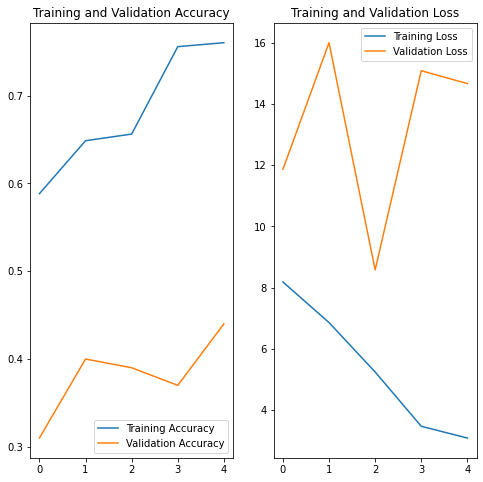

In [92]:
loss(history)

### Model 3 - Re-run

In [93]:
train_generator = generator_new(train_path, train_doc, batch_size)
val_generator = generator_new(val_path, val_doc, batch_size)

model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.3500 - categorical_accuracy: 0.4902Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.35003-0.49020-2.25941-0.17000.h5
23/23 [==============================] - 156s 7s/step - loss: 1.3500 - categorical_accuracy: 0.4902 - val_loss: 2.2594 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.1574 - categorical_accuracy: 0.5279
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.15738-0.52790-2.96342-0.13000.h5
23/23 [==============================] - 156s 7s/step - loss: 1.1574 - categorical_accuracy: 0.5279 - val_loss: 2.9634 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.1210 - categorical_accuracy: 0.5747
Epoch 3: saving model to 

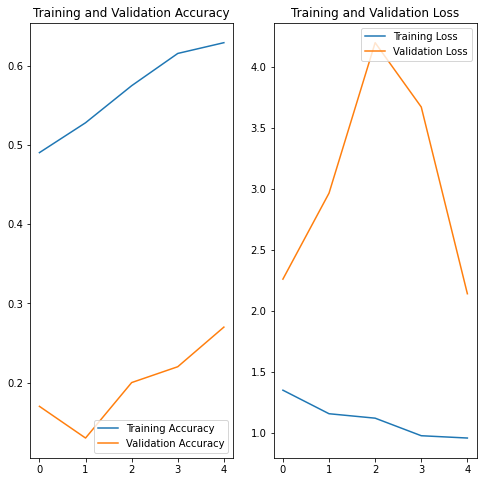

In [94]:
loss(history)

### Model - 11 - Model 3 re-run above has given good results. Increasing the number of filters per layer

In [95]:
# Define Model

model_11 = Sequential()

model_11.add(Conv3D(16,(3,3,3),padding='same',  input_shape= (15,img_size_ht,img_size_wd,3)))
model_11.add(BatchNormalization())
model_11.add(Activation('relu'))
model_11.add(MaxPooling3D(pool_size= (2,2,2)))

model_11.add(Conv3D(32,(1,3,3), padding='same'))
model_11.add(BatchNormalization())
model_11.add(Activation('relu'))
model_11.add(Dropout(0.25))
model_11.add(MaxPooling3D(pool_size= (2,2,2)))

model_11.add(Conv3D(64,(1,2,2), padding='same'))
model_11.add(BatchNormalization())
model_11.add(Activation('relu'))
model_11.add(MaxPooling3D(pool_size= (1,3,3)))

model_11.add(Conv3D(128,(1,2,2), padding='same'))
model_11.add(BatchNormalization())
model_11.add(Activation('relu'))
model_11.add(Dropout(0.35))
model_11.add(MaxPooling3D(pool_size= (1,3,3)))

model_11.add(Flatten())

model_11.add(Dense(1000, activation='relu'))
model_11.add(Dropout(0.25))

model_11.add(Dense(500, activation='relu'))
model_11.add(Dropout(0.35))

model_11.add(Dense(5, activation='softmax'))

In [96]:
model_11 = Sequential()
lrelu = lambda x: LeakyReLU(alpha=0.1)(x)

model_11.add(TimeDistributed(Conv2D(16, (3,3), padding = "same"), input_shape=(15,img_size_ht,img_size_wd,3)))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(Activation(lrelu)))
# model_11.add(TimeDistributed(Dropout(0.2)))
            
model_11.add(TimeDistributed(Conv2D(32,(3,3),padding = "same")))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(Activation(lrelu)))
# model_11.add(TimeDistributed(Dropout(0.2)))
# model_11.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))
model_11.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_11.add(TimeDistributed(Conv2D(64, (3,3),  padding = "same")))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(Activation(lrelu)))
# model_11.add(TimeDistributed(Dropout(0.2)))
model_11.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))
            
model_11.add(TimeDistributed(Conv2D(128,(3,3), padding = "same")))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(Activation(lrelu)))
# model_11.add(TimeDistributed(Dropout(0.2)))
            
model_11.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_11.add(TimeDistributed(Conv2D(256,(3,3), padding = "same")))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(Activation(lrelu)))
# model_11.add(TimeDistributed(Dropout(0.2)))
            
model_11.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))


model_11.add(TimeDistributed(Flatten()))
# model_11.add(LSTM(256,dropout=0.25, recurrent_dropout=0.35, return_sequences=True))
model_11.add(LSTM(512,dropout=0.3))
model_11.add(Dense(512, activation=lrelu))
model_11.add(Dropout(0.3))

model_11.add(Dense(5, activation='softmax'))

In [97]:
optimiser = Adam(learning_rate=0.001) 
model_11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_11.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_89 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_90 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_91 (TimeDi  (None, 15, 120, 120, 16)  0        
 stributed)                                                      
                                                                 
 time_distributed_92 (TimeDi  (None, 15, 120, 120, 32)  4640     
 stributed)                                                      
                                                                 
 time_distributed_93 (TimeDi  (None, 15, 120, 120, 32

In [98]:
train_generator = generator_new(train_path, train_doc, batch_size)
val_generator = generator_new(val_path, val_doc, batch_size)

model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.6481 - categorical_accuracy: 0.2745Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.64807-0.27451-1.69568-0.18000.h5
23/23 [==============================] - 191s 8s/step - loss: 1.6481 - categorical_accuracy: 0.2745 - val_loss: 1.6957 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.4729 - categorical_accuracy: 0.3605
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.47291-0.36048-1.90888-0.24000.h5
23/23 [==============================] - 186s 8s/step - loss: 1.4729 - categorical_accuracy: 0.3605 - val_loss: 1.9089 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.2859 - categorical_accuracy: 0.4495
Epoch 3: saving model to 

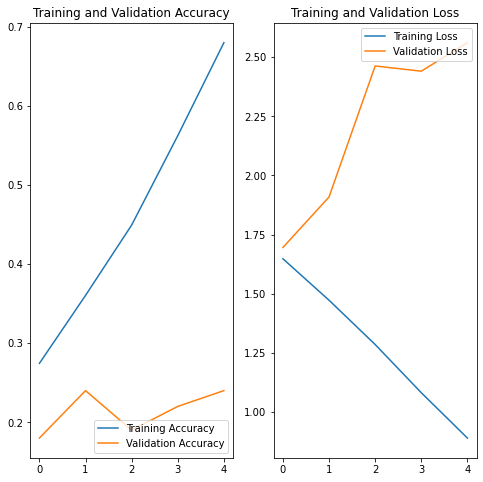

In [99]:
loss(history)

### Model 7 - Re-run

In [100]:
train_generator = generator_new(train_path, train_doc, batch_size, factor_ht = 20, factor_wd = 20)
val_generator = generator_new(val_path, val_doc, batch_size, factor_ht = 20, factor_wd = 20)

model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.1343 - categorical_accuracy: 0.5641Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.13430-0.56410-2.59086-0.21000.h5
23/23 [==============================] - 178s 8s/step - loss: 1.1343 - categorical_accuracy: 0.5641 - val_loss: 2.5909 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.0131 - categorical_accuracy: 0.6440
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.01308-0.64404-2.41097-0.18000.h5
23/23 [==============================] - 184s 8s/step - loss: 1.0131 - categorical_accuracy: 0.6440 - val_loss: 2.4110 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 0.9426 - categorical_accuracy: 0.6471
Epoch 3: saving model to 

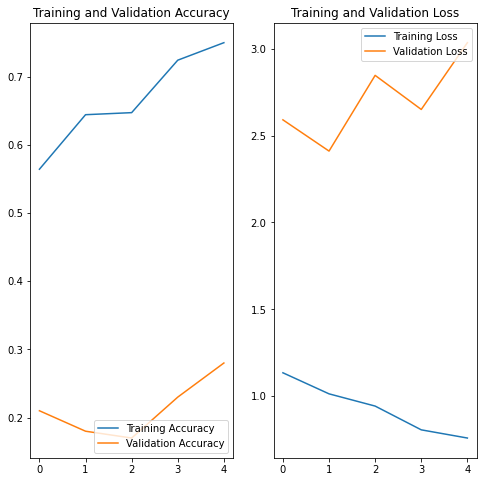

In [101]:
loss(history)

### Model 8 - Re-run

In [102]:
train_generator = generator_new(train_path, train_doc, batch_size)
val_generator = generator_new(val_path, val_doc, batch_size)

model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.1863 - categorical_accuracy: 0.5656Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.18631-0.56561-2.56531-0.21000.h5
23/23 [==============================] - 88s 4s/step - loss: 1.1863 - categorical_accuracy: 0.5656 - val_loss: 2.5653 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 0.8745 - categorical_accuracy: 0.6727
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-0.87449-0.67270-3.64771-0.26000.h5
23/23 [==============================] - 87s 4s/step - loss: 0.8745 - categorical_accuracy: 0.6727 - val_loss: 3.6477 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 0.8895 - categorical_accuracy: 0.6757
Epoch 3: saving model to Ge

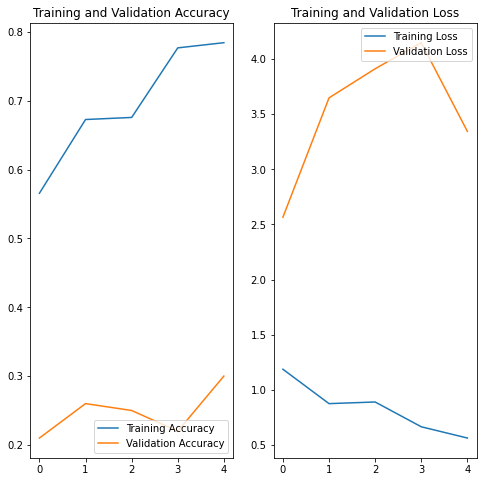

In [103]:
loss(history)

### Model 9 - Re-run

In [104]:
train_generator = generator_new(train_path, train_doc, batch_size)
val_generator = generator_new(val_path, val_doc, batch_size)

model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.6520 - categorical_accuracy: 0.1976Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.65196-0.19759-1.61783-0.18000.h5
23/23 [==============================] - 103s 5s/step - loss: 1.6520 - categorical_accuracy: 0.1976 - val_loss: 1.6178 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.6269 - categorical_accuracy: 0.2187
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.62687-0.21870-1.61649-0.15000.h5
23/23 [==============================] - 103s 5s/step - loss: 1.6269 - categorical_accuracy: 0.2187 - val_loss: 1.6165 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.6369 - categorical_accuracy: 0.1870
Epoch 3: saving model to 

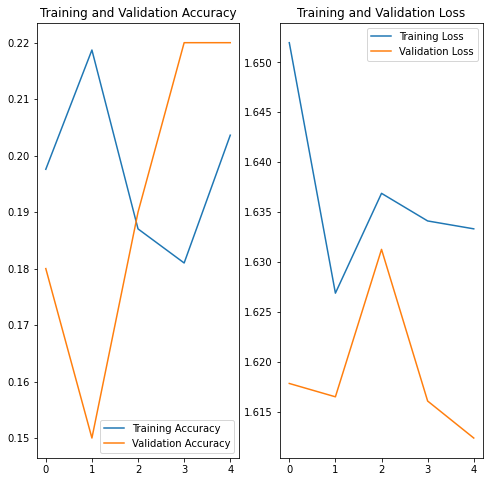

In [105]:
loss(history)

### Model 10 - Re-run

In [106]:
train_generator = generator_new(train_path, train_doc, batch_size)
val_generator = generator_new(val_path, val_doc, batch_size)

model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model_10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.7367 - categorical_accuracy: 0.1991Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.73670-0.19910-1.65917-0.23000.h5
23/23 [==============================] - 134s 6s/step - loss: 1.7367 - categorical_accuracy: 0.1991 - val_loss: 1.6592 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.7397 - categorical_accuracy: 0.2021
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-1.73967-0.20211-1.67290-0.25000.h5
23/23 [==============================] - 134s 6s/step - loss: 1.7397 - categorical_accuracy: 0.2021 - val_loss: 1.6729 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.7990 - categorical_accuracy: 0.2066
Epoch 3: saving model to 

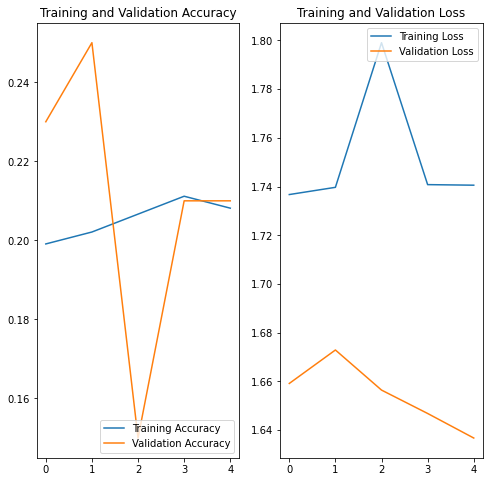

In [107]:
loss(history)

In [108]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [109]:
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(15,img_size_ht,img_size_wd,3)))


for layer in model.layers:
    layer.trainable = False


model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(256))
model.add(Dropout(0.2))

model.add(Dense(256,activation='elu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))


optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_109 (TimeD  (None, 15, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_110 (TimeD  (None, 15, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_111 (TimeD  (None, 15, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_112 (TimeD  (None, 15, 1024)         0         
 istributed)                                                     
                                                                 
 gru_6 (GRU)                 (None, 256)             

In [110]:
train_generator = generator_new(train_path, train_doc, batch_size)
val_generator = generator_new(val_path, val_doc, batch_size)

model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.1111 - categorical_accuracy: 0.5581Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00001-1.11112-0.55807-0.93363-0.62000.h5
23/23 [==============================] - 92s 4s/step - loss: 1.1111 - categorical_accuracy: 0.5581 - val_loss: 0.9336 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 0.3233 - categorical_accuracy: 0.8884
Epoch 2: saving model to Gesture_recog_2022-04-1111_13_38.348058\model-00002-0.32330-0.88839-0.48167-0.81000.h5
23/23 [==============================] - 87s 4s/step - loss: 0.3233 - categorical_accuracy: 0.8884 - val_loss: 0.4817 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 0.1031 - categorical_accuracy: 0.9653
Epoch 3: saving model to Ge

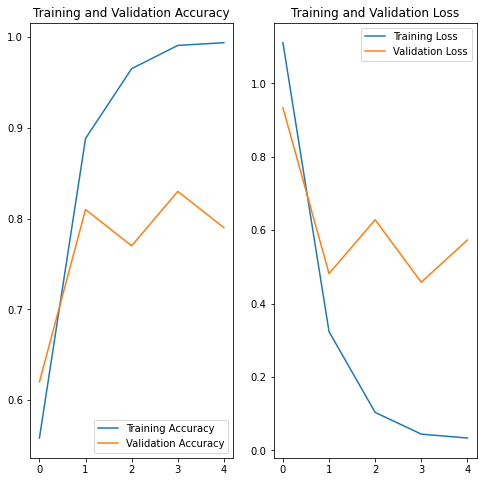

In [111]:
loss(history)